No. of images: 267
2d_images\ID_0000_Z_0142.tif
2d_masks\ID_0000_Z_0142.tif
(1, 256, 256)
X_train - len/shape: 213 (213, 256, 256, 1)
Y_train - len/shape: 213 (213, 256, 256, 1)
X_val  - len/shape: 27 (27, 256, 256, 1)
Y_val  - len/shape: 27 (27, 256, 256, 1)
X_test  - len/shape: 27 (27, 256, 256, 1)
Y_test  - len/shape: 27 (27, 256, 256, 1)


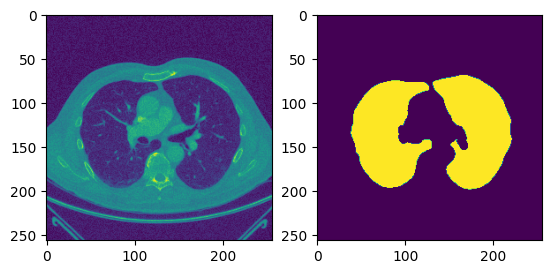

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize
import os, glob
import zipfile
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D, BatchNormalization
from keras.models import Model, load_model
from keras.callbacks import ReduceLROnPlateau
# Import libraries
import os
import pandas as pd  # Utd for data manipulation and analysis
import numpy as np  # Used for numerical operations
import matplotlib.pyplot as plt  # Used for creating static, animated, and interactive visualizations
import matplotlib.image as mpimg  # Used for reading and writing images
import seaborn as sns  # Statistical data visualization library based on matplotlib
from glob import glob    # finds all the pathnames matching a specified pattern according to the rules used by the Unix shell
from skimage.io import imread #used to read image and visualize the image
# Set the seed for random number generator
np.random.seed(2)

# Import sklearn functions
from sklearn.model_selection import train_test_split  # Split dataset into training and testing sets
from sklearn.metrics import confusion_matrix  # Evaluate the accuracy of classification algorithm
import itertools  # Standard library for creating iterators for efficient looping

# Import Keras functions
from keras.layers import *  # Import all layers from keras.layers module
from keras.optimizers import Adam  # Adam optimization algorithm
from keras.preprocessing.image import ImageDataGenerator  # Data augmentation
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint  # Callbacks for reducing learning rate and saving models
from keras.models import Model, load_model, save_model, Sequential  # Model-related functions
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Conv2DTranspose  # Common layers
from keras.layers import Activation,Input,LSTM, Conv1D  # More layers
from keras.layers import BatchNormalization, Reshape  # Even more layers
from keras.optimizers import Adam # More optimization algorithms
# unzip 2d images of lung CT
path = r'D:\13 trimester\BioInformatics\lung dataset\2d_images.zip'
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall('2d_images')
    
# unzip 2d masks of lung CT
path = r'D:\13 trimester\BioInformatics\lung dataset\2d_masks.zip'
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall('2d_masks')
DS_FACT = 2  # Downsample factor
SEED = 42  # Seed for random number generator

# Create lists of image and mask files
all_image_files = glob(os.path.join('2d_images/*.tif'))  # List of all image files
all_mask_files = glob(os.path.join('2d_masks/*.tif'))  # List of all mask files

# Print information about the dataset
print('No. of images:', len(all_image_files))  # Print the number of image files
print(all_image_files[0])  # Print the first image file path
print(all_mask_files[0])
# Import necessary libraries
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the test image and mask
test_image = np.expand_dims(imread(all_image_files[0])[::2, ::2], 0)  # Load the test image, downsample by a factor of 2, and add a batch dimension
test_mask = np.expand_dims(imread(all_mask_files[0])[::2, ::2], 0) / 255.0  # Load the test mask, downsample by a factor of 2, add a batch dimension, and normalize to [0, 1]

# Plot the test image and mask
fig, (ax1, ax2) = plt.subplots(1, 2)  # Create a subplot with 1 row and 2 columns
ax1.imshow(test_image[0])  # Display the test image in the first subplot, specifying the colormap as gray
ax2.imshow(test_mask[0])  # Display the test mask in the second subplot

# Print the shape of the test image
print(test_image.shape)  # Print the shape of the test image array
# Assuming 'all_image_files' and 'all_mask_files' are lists containing file paths
images = [np.expand_dims(imread(i)[::DS_FACT, ::DS_FACT], -1) for i in all_image_files]
masks = [np.expand_dims(imread(i)[::DS_FACT, ::DS_FACT] / 255., -1) for i in all_mask_files]

# Convert lists to NumPy arrays
images, masks = np.array(images), np.array(masks)

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(images, masks, test_size=0.2, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED)

print('X_train - len/shape:', len(X_train), X_train.shape)
print('Y_train - len/shape:', len(y_train), y_train.shape)
print('X_val  - len/shape:', len(X_val), X_val.shape)
print('Y_val  - len/shape:', len(y_val), y_val.shape)
print('X_test  - len/shape:', len(X_test), X_test.shape)
print('Y_test  - len/shape:', len(y_test), y_test.shape)

# Proposed Model

In [2]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, BatchNormalization

def unet(inputs, n=64):
    # Encoder
    conv1 = Conv2D(n, (3, 3), activation='relu', kernel_initializer='glorot_normal', padding='same')(inputs)
    conv1 = Conv2D(n, (3, 3), activation='relu', kernel_initializer='glorot_normal', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.2)(pool1)

    conv2 = Conv2D(n*2, (3, 3), activation='relu', kernel_initializer='glorot_normal', padding='same')(pool1)
    conv2 = Conv2D(n*2, (3, 3), activation='relu', kernel_initializer='glorot_normal', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.2)(pool2)

    # Bottleneck
    convm = Conv2D(n*4, (3, 3), activation='relu', kernel_initializer='glorot_normal', padding='same')(pool2)
    convm = Conv2D(n*4, (3, 3), activation='relu', kernel_initializer='glorot_normal', padding='same')(convm)

    # Decoder
    up1 = Conv2DTranspose(n*2, (2, 2), strides=(2, 2), padding='same')(convm)
    concat1 = concatenate([up1, conv2])
    concat1 = Dropout(0.2)(concat1)                   
    conv3 = Conv2D(n*2, (3, 3), activation='relu', kernel_initializer='glorot_normal', padding='same')(concat1)
    conv3 = Conv2D(n*2, (3, 3), activation='relu', kernel_initializer='glorot_normal', padding='same')(conv3)

    up2 = Conv2DTranspose(n, (2, 2), strides=(2, 2), padding='same')(conv3)
    concat2 = concatenate([up2, conv1])
    concat2 = Dropout(0.2)(concat2) 
    conv4 = Conv2D(n, (3, 3), activation='relu', kernel_initializer='glorot_normal', padding='same')(concat2)
    conv4 = Conv2D(n, (3, 3), activation='relu', kernel_initializer='glorot_normal', padding='same')(conv4)

    output = Conv2D(1, (1, 1), activation='sigmoid')(conv4)

    return Model(inputs=[inputs], outputs=[output])


In [3]:
input_img = Input(X_train.shape[1:], name='img')
n_filters   = 32

model = unet(input_img, n_filters)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [4]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-lung.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [5]:
history = model.fit(X_train, y_train, batch_size=10, epochs=50, callbacks=callbacks, \
                    validation_data=(X_test, y_test))

Epoch 1/50
22/22 [==============================] - ETA: 0s - loss: 3.8790 - accuracy: 0.6998
Epoch 1: val_loss improved from inf to 0.68827, saving model to model-lung.h5
22/22 [==============================] - 15s 462ms/step - loss: 3.8790 - accuracy: 0.6998 - val_loss: 0.6883 - val_accuracy: 0.6434 - lr: 0.0010
Epoch 2/50
22/22 [==============================] - ETA: 0s - loss: 0.7129 - accuracy: 0.7309
Epoch 2: val_loss improved from 0.68827 to 0.43548, saving model to model-lung.h5
22/22 [==============================] - 7s 301ms/step - loss: 0.7129 - accuracy: 0.7309 - val_loss: 0.4355 - val_accuracy: 0.7676 - lr: 0.0010
Epoch 3/50
22/22 [==============================] - ETA: 0s - loss: 0.4467 - accuracy: 0.7644
Epoch 3: val_loss improved from 0.43548 to 0.38619, saving model to model-lung.h5
22/22 [==============================] - 7s 302ms/step - loss: 0.4467 - accuracy: 0.7644 - val_loss: 0.3862 - val_accuracy: 0.7707 - lr: 0.0010
Epoch 4/50
22/22 [=========================

In [6]:
# save model
model.save('image_segmentation.model')
#model.save(r'D:\13 trimester\BioInformatics\lung dataset\image_segmentation.model')

INFO:tensorflow:Assets written to: image_segmentation.model\assets


INFO:tensorflow:Assets written to: image_segmentation.model\assets


In [7]:
def plot_history(history, title):
    plt.figure(figsize=(10,3))
    # Plot training & validation accuracy values
    plt.subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train acc', 'val acc'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train loss', 'val loss'], loc='upper left')
    plt.show()

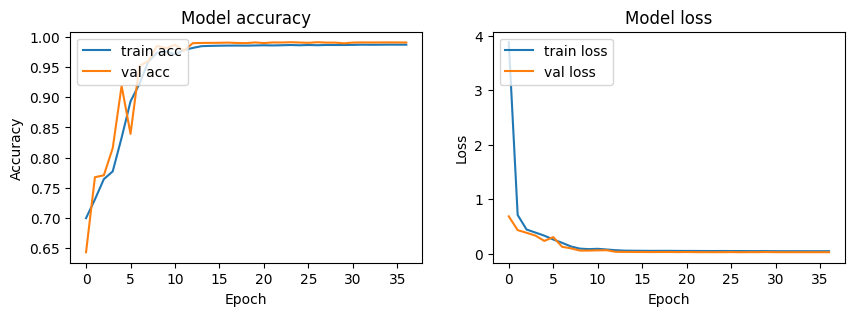

In [8]:
plot_history(history, 'UNet Loss/Accuracy')

In [9]:
model.load_weights('model-lung.h5')

1/1 [==============================] - 1s 946ms/step


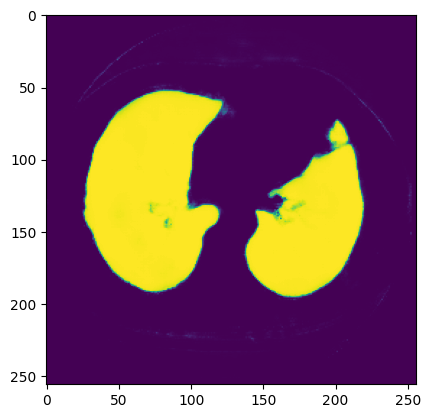

In [10]:
plt.imshow(
    model.predict(X_train[0].reshape(1,256, 256, 1))[0,:,:,0], 
    cmap='viridis')

1/1 [==============================] - 2s 2s/step


C:\Users\babul\AppData\Local\Temp\ipykernel_17384\3349938268.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,3,figsize=(12,6))


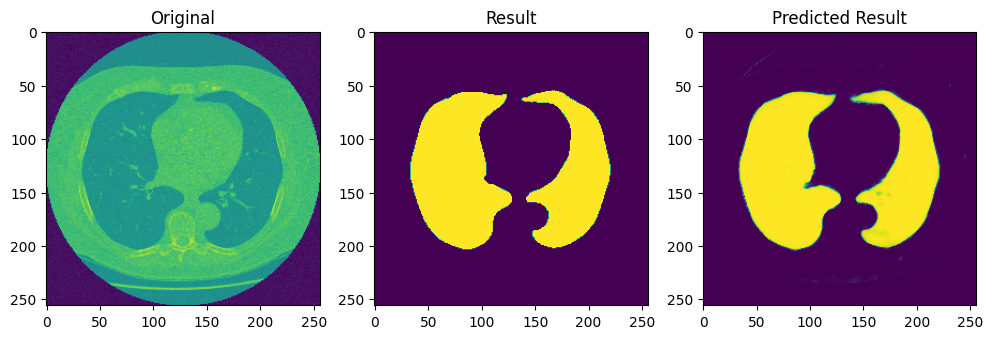

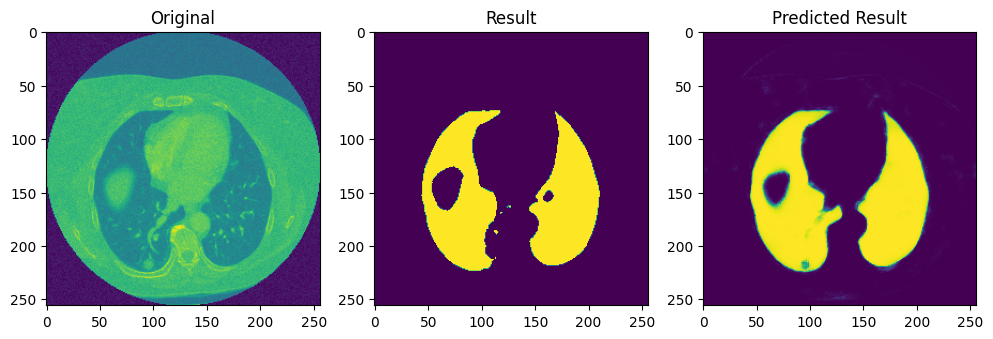

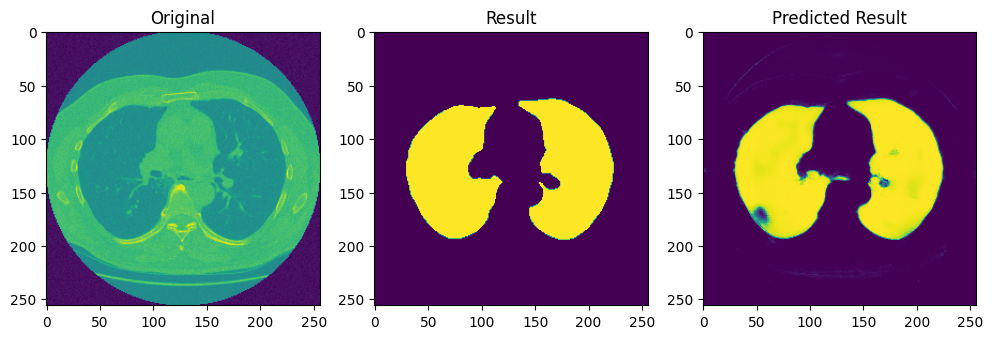

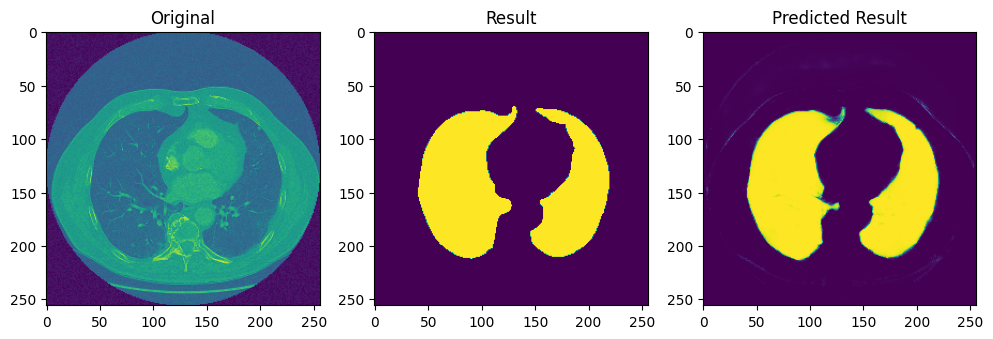

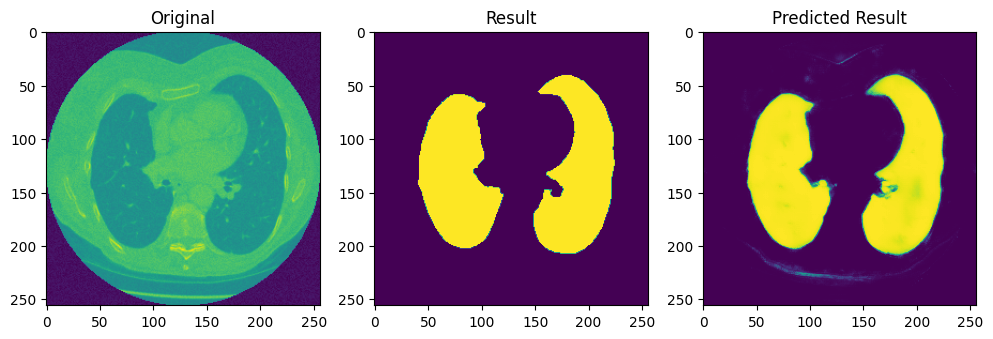

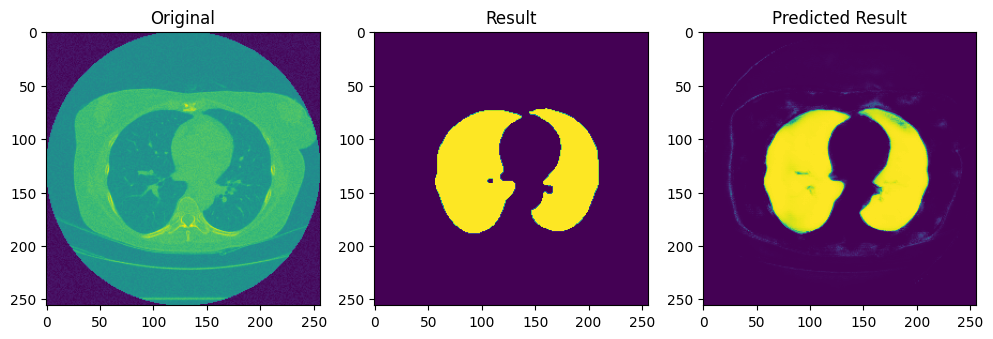

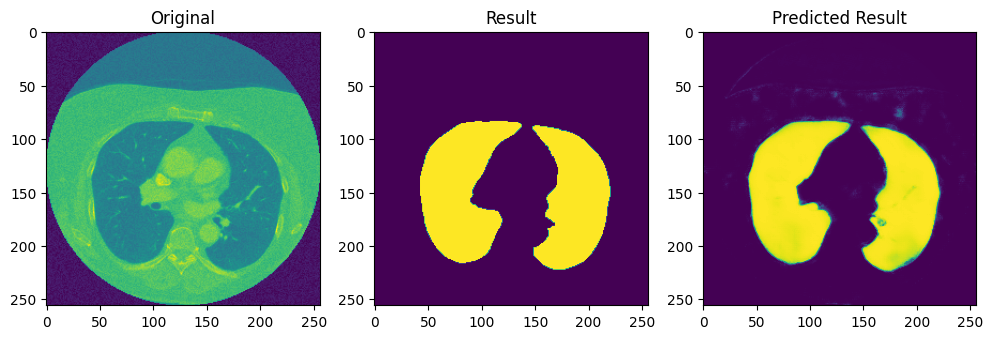

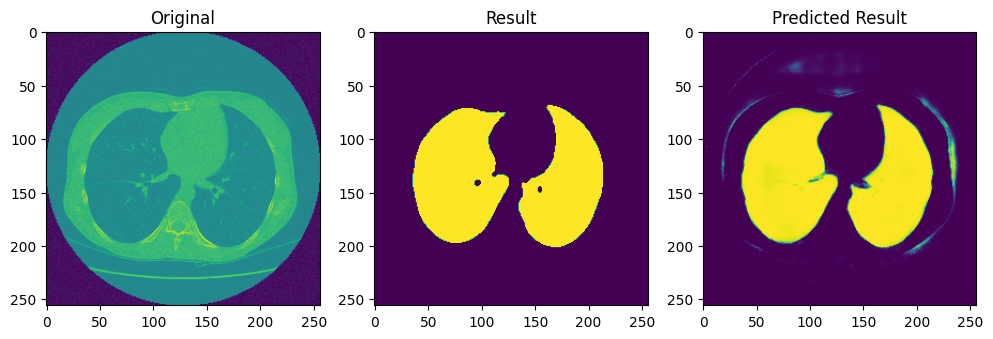

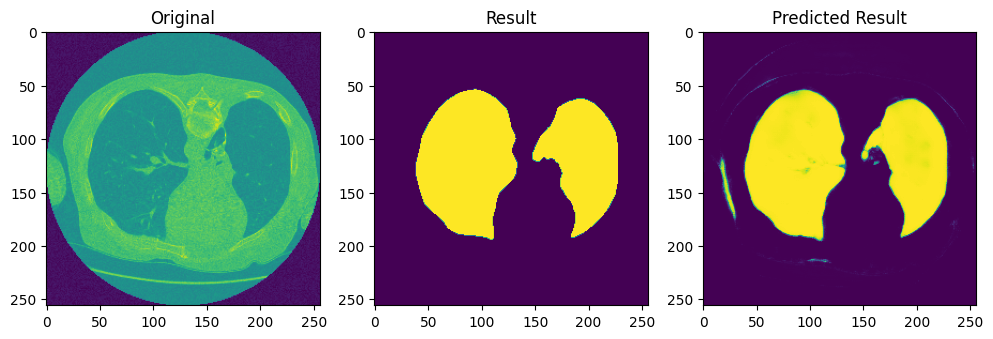

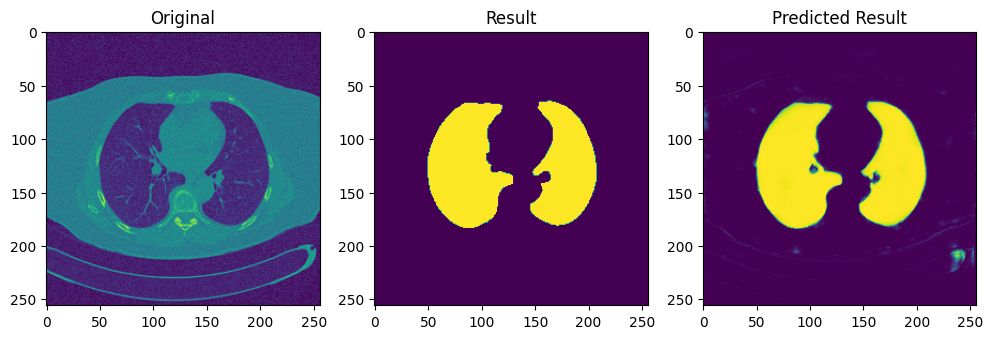

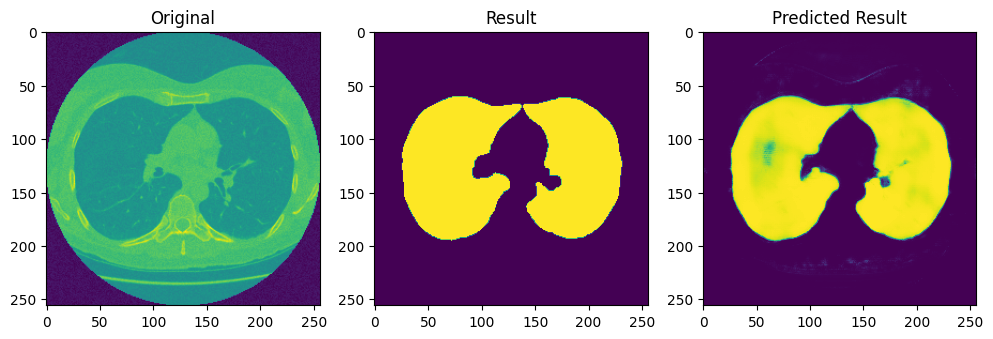

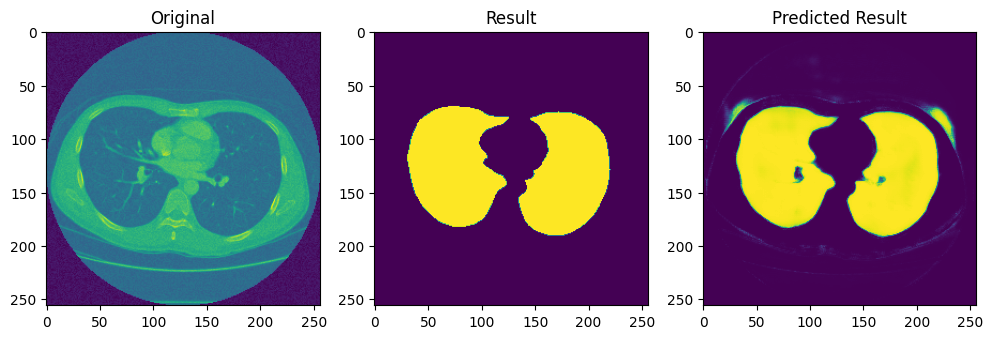

In [11]:
y_predict = model.predict(X_test)

for i in range(X_test.shape[0]): 
    fig, ax = plt.subplots(1,3,figsize=(12,6))
    ax[0].set_title('Original')
    ax[1].set_title('Result')
    ax[2].set_title('Predicted Result')
    ax[0].imshow(X_test[i,:,:,0], cmap='viridis')
    ax[1].imshow(y_test[i,:,:,0])
    ax[2].imshow(y_predict[i,:,:,0])

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Define a function to compute specificity
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true.flatten(), (y_pred.flatten() > 0.5).astype(int)).ravel()
    return tn / (tn + fp)

# Define a function to compute dice score
def dice_score(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    return 2 * intersection / union

# Evaluate the model on the test set
y_pred = model.predict(X_test)

# Flatten the arrays for binary classification
y_test_flat = y_test.flatten()
y_pred_flat = (y_pred.flatten() > 0.5).astype(int)

# Compute and print the metrics
precision = precision_score(y_test_flat, y_pred_flat)
recall = recall_score(y_test_flat, y_pred_flat)
f1 = f1_score(y_test_flat, y_pred_flat)
spec = specificity(y_test, y_pred)
dice = dice_score(y_test_flat, y_pred_flat)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Specificity: {spec:.4f}')
print(f'Dice Score: {dice:.4f}')


1/1 [==============================] - 0s 19ms/step
Precision: 0.9736
Recall: 0.9888
F1 Score: 0.9812
Specificity: 0.9918
Dice Score: 0.9812


In [13]:
from sklearn.metrics import accuracy_score

# Flatten the arrays for binary classification
y_test_flat = y_test.flatten()
y_pred_flat = (y_pred.flatten() > 0.5).astype(int)

# Compute accuracy
accuracy = accuracy_score(y_test_flat, y_pred_flat)

print(f'Accuracy: {accuracy:.4f}')


Accuracy: 0.9911


# Jaccard Score (also known as Intersection over Union or IoU)

In [14]:
from sklearn.metrics import confusion_matrix

# Flatten the arrays for binary classification
y_test_flat = y_test.flatten()
y_pred_flat = (y_pred.flatten() > 0.5).astype(int)

# Compute confusion matrix
conf_mat = confusion_matrix(y_test_flat, y_pred_flat)

# Calculate true positives, false positives, and false negatives
tp = conf_mat[1, 1]
fp = conf_mat[0, 1]
fn = conf_mat[1, 0]

# Calculate Intersection over Union (IoU)
iou = tp / (tp + fp + fn)

print(f'Intersection over Union (IoU): {iou:.4f}')


Intersection over Union (IoU): 0.9630


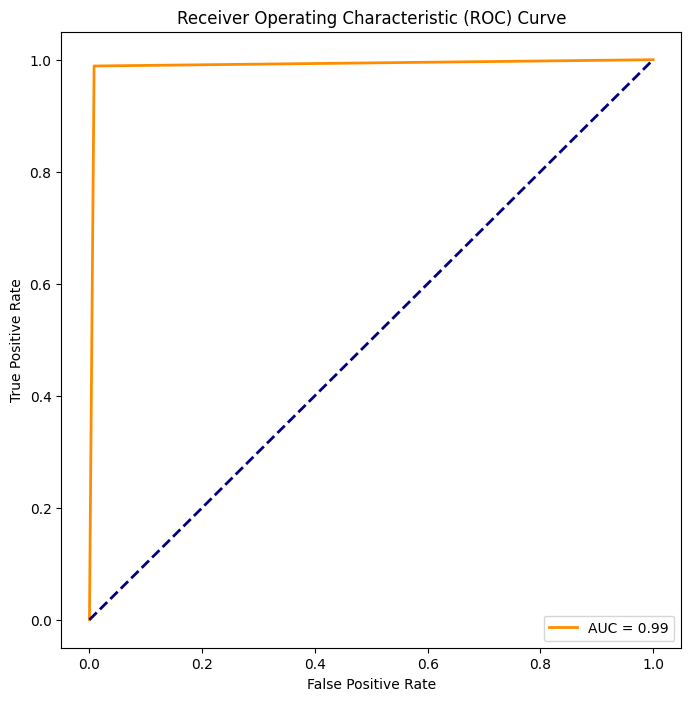

In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_flat, y_pred_flat)

# Compute Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


Mean: -651.2952242497382, Median: -656.9117191415684, Standard Deviation: 40.56862966949963


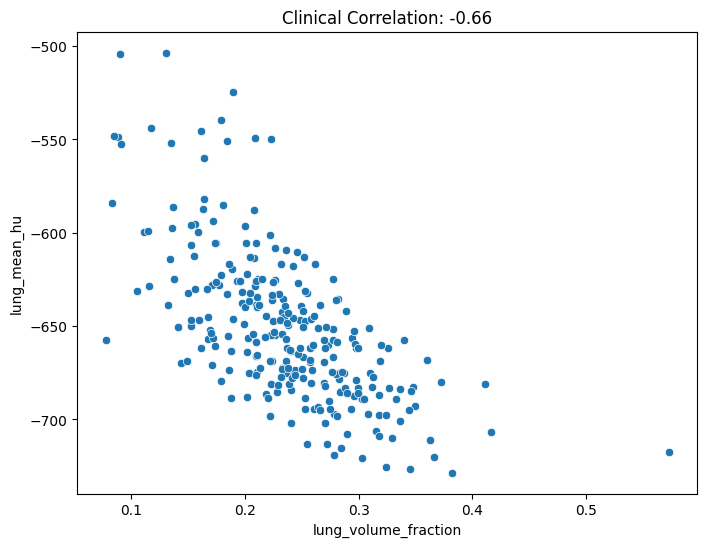

Mean Squared Error: 6081.09


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

# Load CSV file
csv_file_path = r'D:\13 trimester\BioInformatics\lung dataset\lung_stats.csv'
df = pd.read_csv(csv_file_path)

# Choose the column for analysis
column_name = 'lung_mean_hu'

# Statistical Analysis
mean_value = df[column_name].mean()
median_value = df[column_name].median()
std_dev_value = df[column_name].std()

print(f'Mean: {mean_value}, Median: {median_value}, Standard Deviation: {std_dev_value}')

# Visualize distribution
plt.figure(figsize=(8, 6))
sns.histplot(df[column_name], kde=True)
plt.title('Distribution of Values')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

# Correlation Analysis
# Assuming 'feature_column' corresponds to a feature in your CT images
feature_column = 'lung_area_px'
correlation = df[column_name].corr(df[feature_column])

# Visualization using scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df[column_name], y=df[feature_column])
plt.title(f'Correlation: {correlation:.2f}')
plt.xlabel(column_name)
plt.ylabel(feature_column)
plt.show()

# Clinical Correlations
# Assuming 'clinical_column' contains clinical data
clinical_column = 'lung_volume_fraction'
clinical_correlation = df[clinical_column].corr(df[column_name])

# Visualization using scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df[clinical_column], y=df[column_name])
plt.title(f'Clinical Correlation: {clinical_correlation:.2f}')
plt.xlabel(clinical_column)
plt.ylabel(column_name)
plt.show()

# Machine Learning
# Assuming 'label_column' contains labels for your machine learning task
label_column = 'lung_pd95_hu'
X = df[[column_name]]  # Features
y = df[label_column]  # Labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a RandomForestRegressor for regression tasks
model = RandomForestRegressor()
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')

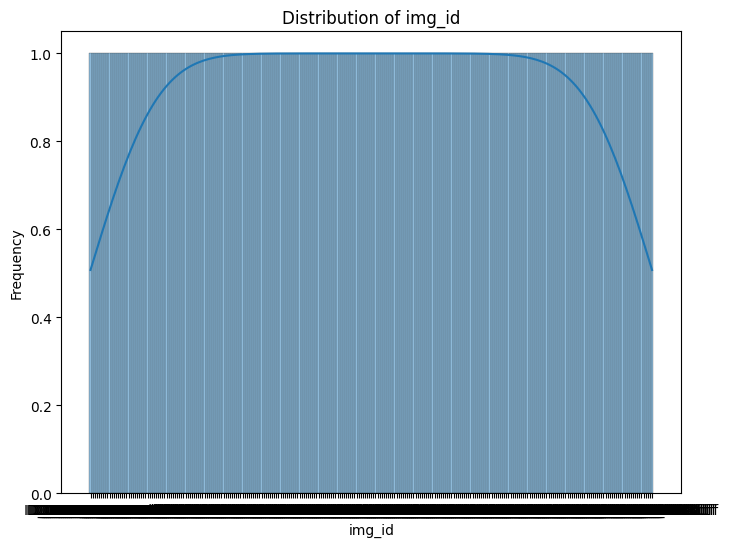

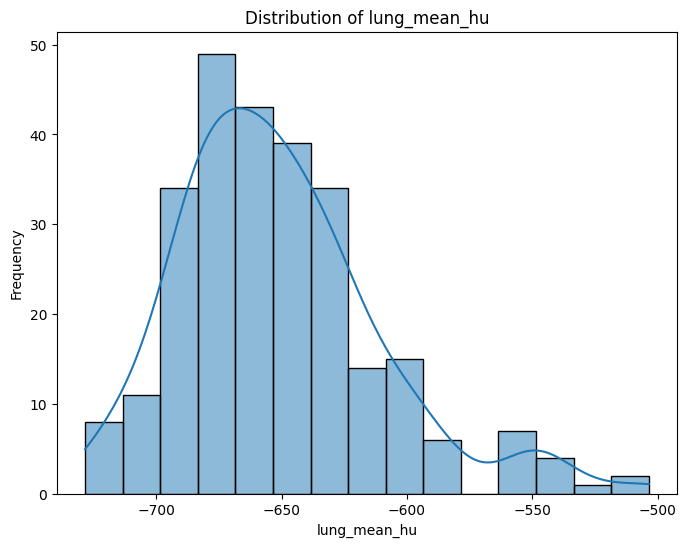

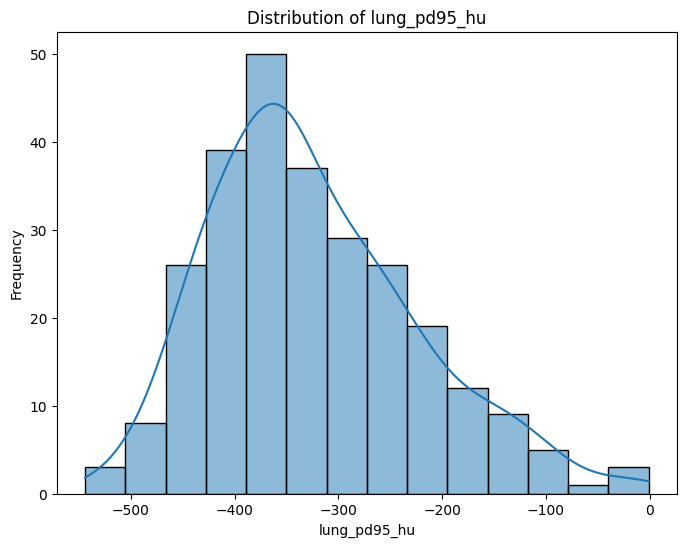

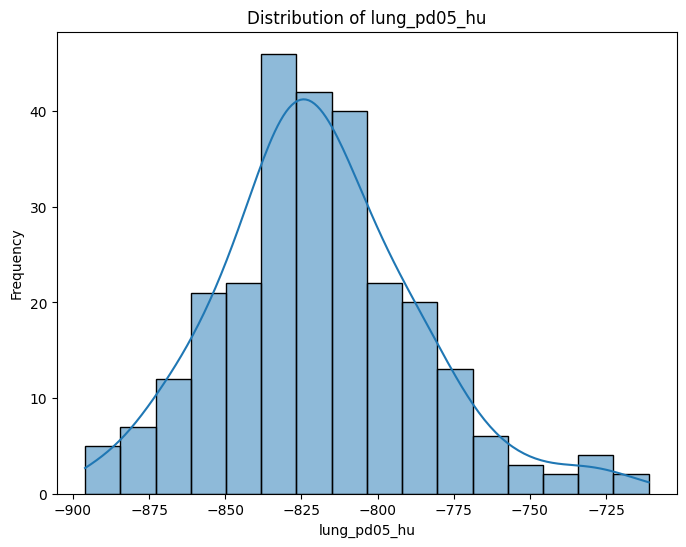

Descriptive Statistics:
        lung_area_px  lung_area_mm2  lung_volume_fraction  lung_mean_hu  \
count     267.000000     267.000000            267.000000    267.000000   
mean    61675.385768   43365.505618              0.235273   -651.295224   
std     17278.388828   12148.867145              0.065912     40.568630   
min     20305.000000   14276.953125              0.077457   -728.454196   
25%     50942.500000   35818.945312              0.194330   -679.802947   
50%     61687.000000   43373.671875              0.235317   -656.911719   
75%     72714.000000   51127.031250              0.277382   -630.617434   
max    150273.000000  105660.703125              0.573246   -503.530575   

       lung_pd95_hu  lung_pd05_hu  
count    267.000000    267.000000  
mean    -324.279401   -819.291199  
std      100.024352     32.758803  
min     -544.000000   -896.000000  
25%     -395.000000   -838.500000  
50%     -345.000000   -822.000000  
75%     -266.000000   -801.000000  
max       -1

In [18]:
# Explore the distribution of each variable
for column in df.columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

# Descriptive statistics
desc_stats = df.describe()
print("Descriptive Statistics:")
print(desc_stats)


C:\Users\babul\miniconda3\envs\tensorflow\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


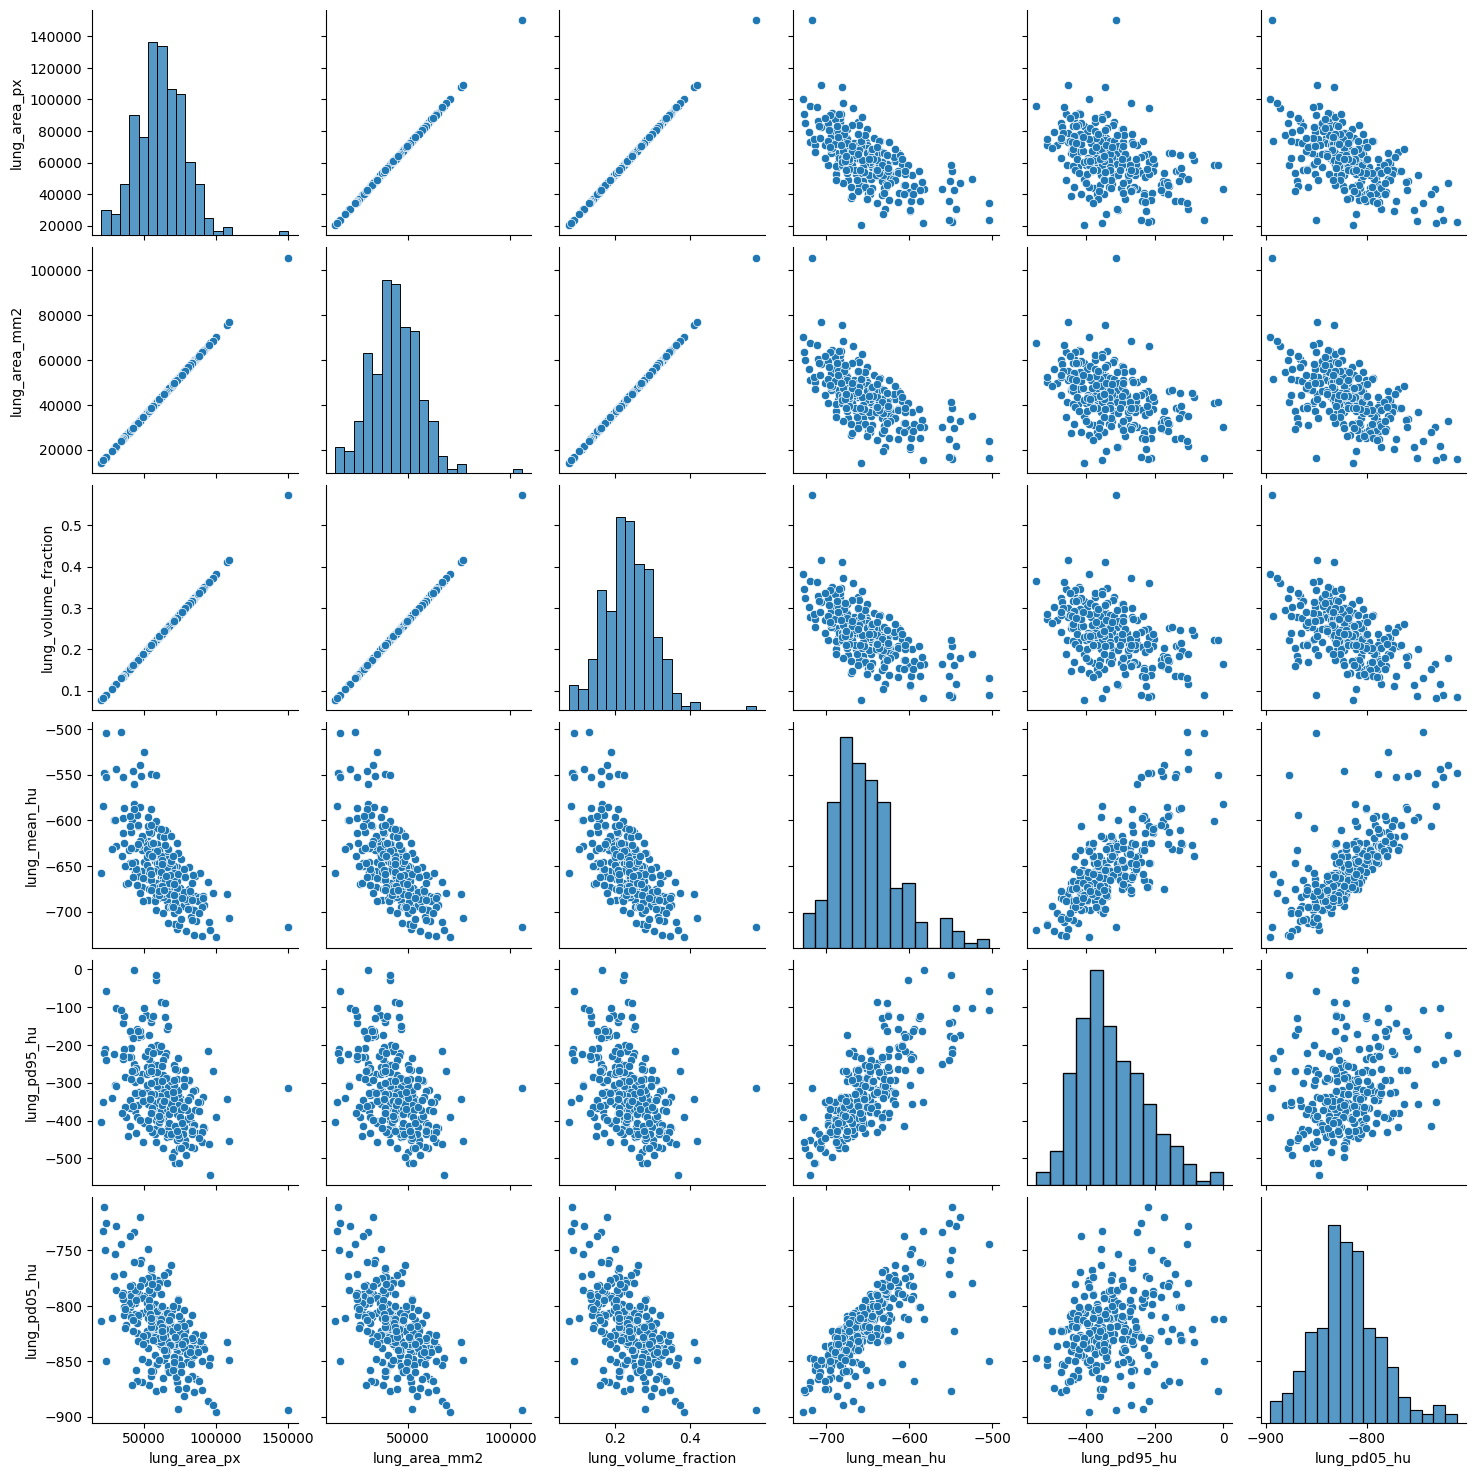

In [19]:
# Visualize relationships using a pairplot
sns.pairplot(df[['lung_area_px', 'lung_area_mm2', 'lung_volume_fraction', 'lung_mean_hu', 'lung_pd95_hu', 'lung_pd05_hu']])
plt.show()


In [20]:
from sklearn.metrics import mean_absolute_error

# Ensure y_test and y_predict are NumPy arrays
y_test = np.array(y_test)
y_predict = np.array(y_predict)

# Calculate MAE for each image separately
mae_per_image = np.mean(np.abs(y_test - y_predict), axis=(1, 2, 3))

# Compute mean MAE across all images
mean_mae = np.mean(mae_per_image)

print(f'Mean Absolute Error: {mean_mae:.4f}')

Mean Absolute Error: 338.1263
